In [6]:
# Import necessary libraries
from pathlib import Path
from typing import List

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
from IPython.display import display
from matplotlib import pyplot
from mpl_toolkits import mplot3d
from skimage.measure import marching_cubes
from stl import mesh

from imgtools.ops import Resize, Rotate, bounding_box
from imgtools.utils.imageutils import (
    idxs_to_physical_points,
    image_to_array,
    physical_points_to_idxs,
)

In [2]:
def create_simple_image(size=(100, 100, 10), shape='circle') -> sitk.Image:
	"""
	Creates a SimpleITK image with a basic shape.
	"""
	image_array = np.zeros(size, dtype=np.uint8)
	center = np.array(size) // 2

	if shape == 'circle':
		radius = min(size[:2]) // 4
		# Draw the circle only on the middle slice
		z = center[2]
		for x in range(size[0]):
			for y in range(size[1]):
				if (x - center[0])**2 + (y - center[1])**2 <= radius**2:
					image_array[x, y, z] = 1
	
	image = sitk.GetImageFromArray(image_array)
	return image

# Generate physical points for another mask
def generate_physical_points(image: sitk.Image, spacing=(1.0, 1.0, 1.0)):
	"""
	Generates physical points for a square mask in physical space.
	"""
	origin = np.array(image.GetOrigin())
	square_points = np.array([
		[30.0, 30.0, 5.0],
		[70.0, 30.0, 5.0],
		[70.0, 70.0, 5.0],
		[30.0, 70.0, 5.0]
	])
	return [square_points * np.array(spacing) + origin]

def visualize(image: sitk.Image | np.ndarray, transformed_points: List[np.ndarray] | None = None, slice: int = 5):
	"""
	Visualizes the original image and overlays the transformed points.
	"""
	# Convert image to numpy array
	match image:
		case sitk.Image():
			image_array = sitk.GetArrayViewFromImage(image)
		case np.ndarray():
			image_array = image	
	# Plot the image
	plt.figure(figsize=(10, 10))
	plt.imshow(image_array[slice, :, :], cmap="gray")  # Ensure slice z=5 is displayed
	
	# if transformed_points is not None:
	# 	# Overlay the transformed points
	# 	for points in transformed_points:
	# 		plt.scatter(points[:, 0], points[:, 1], c='red', marker='o', label='Transformed Points')
	
	plt.title("Image with Transformed Points and Mask")
	plt.legend()
	plt.show()




In [17]:
import numpy as np
import SimpleITK as sitk
import trimesh
from scipy.ndimage import binary_fill_holes

# from skimage.morphology import binary_fill_holes
from skimage.segmentation import flood_fill


def stl_to_filled_sitk_padded(stl_path: str, spacing: tuple[float, float, float] = (1.0, 1.0, 1.0), 
							  pad: int = 5) -> sitk.Image:
	"""Convert an STL file to a solid SimpleITK image with a filled interior and padding.

	Parameters
	----------
	stl_path : str
	    Path to the STL file.
	spacing : tuple[float, float, float], optional
	    Voxel spacing (x, y, z), default is (1.0, 1.0, 1.0).
	pad : int, optional
	    Number of voxels to pad around the object, default is 5.

	Returns
	-------
	sitk.Image
	    The filled, padded voxelized representation of the STL model.
	"""
	
	# Load the STL file
	mesh = trimesh.load_mesh(stl_path)

	# Determine voxel size from spacing
	voxel_size = min(spacing)

	# Voxelize the mesh
	voxelized = mesh.voxelized(pitch=voxel_size)

	# Convert voxel grid to numpy array (binary: 1=mesh, 0=background)
	voxel_array = np.array(voxelized.matrix, dtype=np.uint8)

	# Fill internal holes to make the duck solid
	voxel_filled = binary_fill_holes(voxel_array).astype(np.uint8)

	# Add padding around the object
	voxel_padded = np.pad(voxel_filled, pad_width=pad, mode="constant", constant_values=0)

	# Convert to SimpleITK Image
	sitk_image = sitk.GetImageFromArray(voxel_padded)
	sitk_image.SetSpacing(spacing)

	return sitk_image



spacing = (1.0, 1.0, 1.0)
# Load the STL files and add the vectors to the plot
duckfile = '/Users/bhklab/dev/radiomics/med-imagetools/images/obj_1_Tiny Duck.stl'



original = stl_to_filled_sitk_padded(duckfile, spacing=spacing)
print(original.GetSize())

resizer = Resize(size = 50, interpolation='linear', anti_alias=True)

resized_image = resizer(original)

print(resized_image.GetSize())

size = resized_image.GetSize()
bbox = bounding_box(resized_image)
center_voxel = [size[0]//2, size[1]//2, size[2]//2]

rotator = Rotate(rotation_centre=center_voxel, angles=[0, 0, 90])

my_image = rotator(resized_image)

(41, 39, 33)
(50, 50, 50)


(50, 50, 50)


IntSlider(value=24, description='Slice:', max=49)

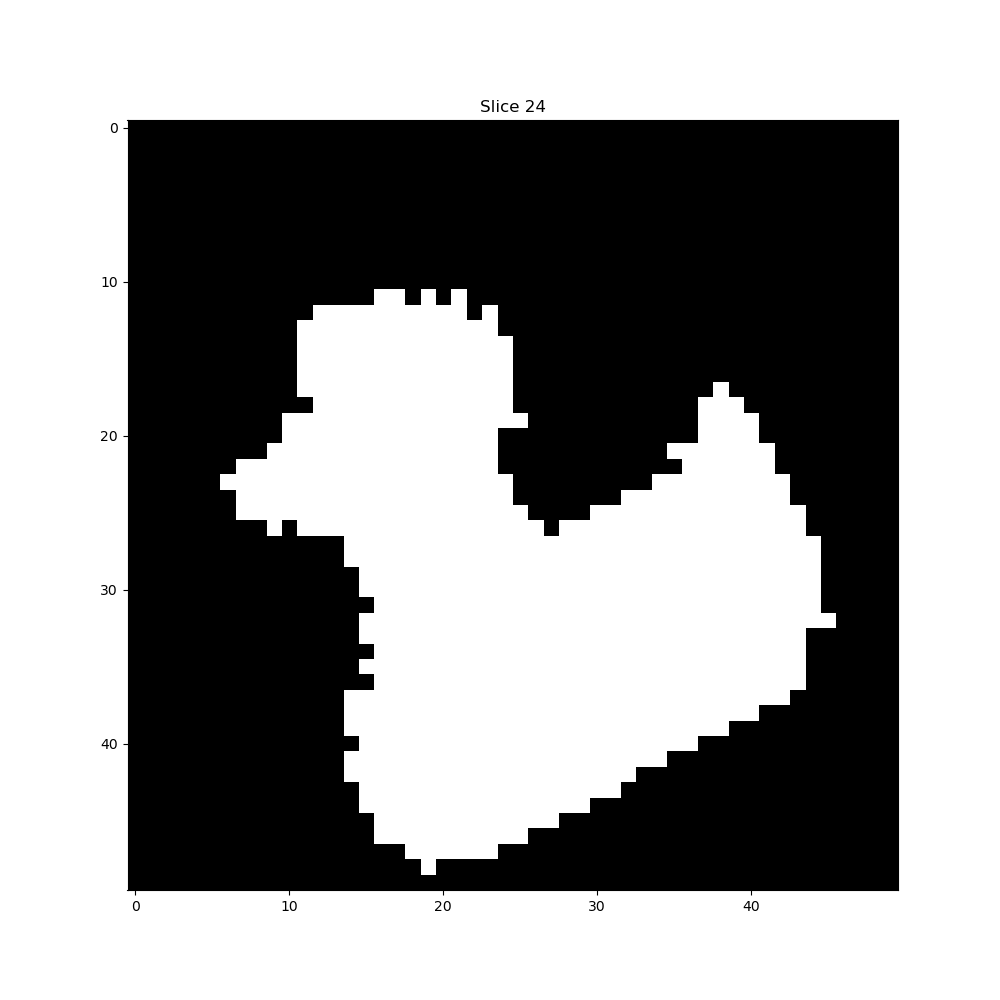

In [18]:
%matplotlib ipympl 


print(my_image.GetSize())
slice_max = my_image.GetSize()[2] - 1

# visualize(sitk_image, slice=slice_max // 2)
# Create a slider widget
slice_slider = widgets.IntSlider(min=0, max=slice_max, step=1, value=slice_max // 2, description='Slice:')
image = my_image
fig, ax = plt.subplots(figsize=(10, 10))

# Define a function to update the visualization based on the slider value
def update_slice(change):
  slice_index = change['new']
  # Convert image to numpy array
  match image:
    case sitk.Image():
      image_array = sitk.GetArrayViewFromImage(image)
    case np.ndarray():
      image_array = image    
  unique_values = np.unique(image_array)
   # Update the image
  ax.clear()
  ax.imshow(image_array[slice_index, :, :], cmap="gray")
  ax.set_title(f"Slice {slice_index}")

# Attach the update function to the slider
slice_slider.observe(update_slice, names='value')

# Display the initial image
update_slice({'new': slice_slider.value})

# Display the slider
display(slice_slider)